In [2]:
import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Now you can import the functions from utils.py
from utils import load_predictions, get_gold_data, score_data
import loguru as logging
import pandas as pd
import glob
import joblib
import os

# Initialize the logger
logger = logging.logger

In [3]:
preds = load_predictions()
preds.sort_values('ds')[['ds', 'y', 'CatBoostRegressor']]

2024-08-23 15:48:32.989 | INFO     | utils:load_predictions:317 - Loading predictions


,ds,y,CatBoostRegressor
0,2024-06-15,816371.131,799804.806379
1,2024-06-16,727934.964,716861.539636
2,2024-06-17,851129.980,849000.151127
3,2024-06-18,886222.722,859070.687359
4,2024-06-19,890934.761,858982.500674
...,...,...,...
124,2024-10-17,NaN,874489.045367
125,2024-10-18,NaN,862455.302638
126,2024-10-19,NaN,797766.763016
127,2024-10-20,NaN,693340.219806


<Axes: xlabel='ds'>

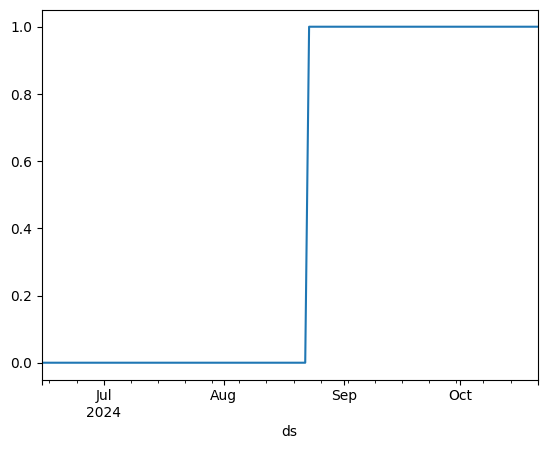

In [164]:
preds.groupby('ds')['y'].apply(lambda x: pd.isna(x).sum()).plot()

In [165]:
df_hist = get_gold_data()
df_hist

2024-08-23 15:40:37.818 | INFO     | utils:get_gold_data:181 - Fetching data from Gold layer for date


,ds,y,unique_id
0,2021-01-01,517292.1985,0
1,2021-01-02,663260.0435,0
2,2021-01-03,656525.3775,0
3,2021-01-04,796937.2295,0
4,2021-01-05,875973.0590,0
...,...,...,...
1325,2024-08-18,744501.7770,0
1326,2024-08-19,880713.2220,0
1327,2024-08-20,927637.6410,0
1328,2024-08-21,931550.5060,0


In [166]:
# Find the extracted joblib file
joblib_files = glob.glob("../model_folder/*.joblib")
if not joblib_files:
    logger.error("No .joblib file found. Unable to proceed with scoring.")

model_path = joblib_files[0]

# Load the trained model
try:
    model = joblib.load(model_path)
    logger.info(f"Model loaded successfully from {model_path}")
except Exception as e:
    logger.error(f"Error loading model: {str(e)}")
    raise


2024-08-23 15:40:51.062 | INFO     | __main__:<module>:11 - Model loaded successfully from ../model_folder/local_model.joblib


In [167]:
preds = model.predict(1)
preds

,unique_id,ds,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor
0,0,2024-08-13,859596.398764,850939.848937,839761.3125,851227.58824


In [168]:
results = df_hist.merge(preds, on=['unique_id', 'ds'])
results

,ds,y,unique_id,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor
0,2024-08-13,844564.07,0,859596.398764,850939.848937,839761.3125,851227.58824


Backfill

In [151]:
from utils import get_gold_data, train_model, split_data
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from load_dotenv import load_dotenv

import joblib

# Initialize logger
logger = logging.logger

# Load environment variables
load_dotenv()

LEVELS = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
RANDOM_STATE = 0
N_ESTIMATORS = 100

# Load environment variables
MODEL_START_DATE = os.environ["MODEL_START_DATE"]
MODEL_SPLIT_DATE = '2024-08-13'

print('Dates:\n')
print(f'MODEL_START_DATE: {MODEL_START_DATE}')
print(f'MODEL_SPLIT_DATE: {MODEL_SPLIT_DATE}')

data = get_gold_data()
df_train, df_oot = split_data(data, MODEL_START_DATE, MODEL_SPLIT_DATE)
models = [
        CatBoostRegressor(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS),
        LGBMRegressor(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS),
        XGBRegressor(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS),
        RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS)
    ]

def create_model(data, models):
    # Train the models
    model_path = "../model_folder/local_model.joblib"
    model = train_model(data, models)
    joblib.dump(model, model_path)

    return model_path

model_path = create_model(df_train, models)

2024-08-23 15:32:36.461 | INFO     | utils:get_gold_data:181 - Fetching data from Gold layer for date


Dates:

MODEL_START_DATE: 2021-02-01
MODEL_SPLIT_DATE: 2024-08-13


2024-08-23 15:32:38.516 | INFO     | utils:train_model:243 - Training model


Learning rate set to 0.275978
0:	learn: 70774.6686066	total: 1.05ms	remaining: 104ms
1:	learn: 58068.3323165	total: 1.52ms	remaining: 74.7ms
2:	learn: 50160.6278422	total: 2.19ms	remaining: 70.9ms
3:	learn: 43511.3050968	total: 2.88ms	remaining: 69.1ms
4:	learn: 38833.1035645	total: 3.57ms	remaining: 67.9ms
5:	learn: 35419.0805799	total: 4.26ms	remaining: 66.8ms
6:	learn: 33237.4263180	total: 5.34ms	remaining: 71ms
7:	learn: 31375.5576179	total: 6.19ms	remaining: 71.2ms
8:	learn: 29826.4886356	total: 6.84ms	remaining: 69.2ms
9:	learn: 28855.5233298	total: 7.47ms	remaining: 67.3ms
10:	learn: 27963.6056265	total: 8.18ms	remaining: 66.2ms
11:	learn: 27308.4279913	total: 9.35ms	remaining: 68.6ms
12:	learn: 26763.3891598	total: 9.98ms	remaining: 66.8ms
13:	learn: 26327.5390211	total: 10.6ms	remaining: 65.3ms
14:	learn: 26027.7827140	total: 11.5ms	remaining: 64.9ms
15:	learn: 25626.6781128	total: 12.6ms	remaining: 66ms
16:	learn: 25290.1811191	total: 13.3ms	remaining: 64.8ms
17:	learn: 24954

In [169]:
# load the model

model = joblib.load(model_path)
model.predict(1)

,unique_id,ds,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor
0,0,2024-08-13,859596.398764,850939.848937,839761.3125,851227.58824


In [170]:
levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
forecasts = model.predict(len(df_oot)+60, level=levels)
forecasts.tail()

/home/pedro/my_project_dir/energy_demand/.venv/lib/python3.10/site-packages/mlforecast/forecast.py:742: UserWarning:

Prediction intervals are calculated using 1-step ahead cross-validation, with a constant width for all horizons. To vary the error by horizon, pass PredictionIntervals(h=h) to the `prediction_intervals` argument when refitting the model.



,unique_id,ds,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor-lo-99,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-lo-80,...,RandomForestRegressor-hi-20,RandomForestRegressor-hi-30,RandomForestRegressor-hi-40,RandomForestRegressor-hi-50,RandomForestRegressor-hi-60,RandomForestRegressor-hi-70,RandomForestRegressor-hi-80,RandomForestRegressor-hi-90,RandomForestRegressor-hi-95,RandomForestRegressor-hi-99
65,0,2024-10-17,858991.309612,879583.937713,890627.3125,854607.656700,805668.795821,809752.234631,814856.533144,825065.130171,...,863665.149595,865440.224629,867215.299663,868990.374696,870765.449730,877752.777755,884740.105780,891727.433805,895221.097818,898016.029028
66,0,2024-10-18,853125.584179,878743.933666,847202.2500,846168.152935,799803.070387,803886.509198,808990.807711,819199.404737,...,855225.645830,857000.720864,858775.795897,860550.870931,862325.945965,869313.273990,876300.602015,883287.930040,886781.594053,889576.525263
67,0,2024-10-19,785450.320603,812396.759735,762026.0625,778798.941015,732127.806811,736211.245621,741315.544135,751524.141161,...,787856.433910,789631.508944,791406.583977,793181.659011,794956.734045,801944.062070,808931.390095,815918.718120,819412.382133,822207.313343
68,0,2024-10-20,686881.813122,725197.904769,679103.6250,691933.229565,633559.299331,637642.738141,642747.036654,652955.633681,...,700990.722460,702765.797494,704540.872527,706315.947561,708091.022595,715078.350620,722065.678645,729053.006670,732546.670683,735341.601892
69,0,2024-10-21,793725.514859,842669.989038,826241.5000,806390.139435,740403.001067,744486.439877,749590.738391,759799.335417,...,815447.632330,817222.707364,818997.782397,820772.857431,822547.932465,829535.260490,836522.588515,843509.916540,847003.580553,849798.511763


In [171]:
test = forecasts.merge(df_oot, how='left', on=['unique_id', 'ds'])
test.tail()

,unique_id,ds,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor-lo-99,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-lo-80,...,RandomForestRegressor-hi-30,RandomForestRegressor-hi-40,RandomForestRegressor-hi-50,RandomForestRegressor-hi-60,RandomForestRegressor-hi-70,RandomForestRegressor-hi-80,RandomForestRegressor-hi-90,RandomForestRegressor-hi-95,RandomForestRegressor-hi-99,y
65,0,2024-10-17,858991.309612,879583.937713,890627.3125,854607.656700,805668.795821,809752.234631,814856.533144,825065.130171,...,865440.224629,867215.299663,868990.374696,870765.449730,877752.777755,884740.105780,891727.433805,895221.097818,898016.029028,NaN
66,0,2024-10-18,853125.584179,878743.933666,847202.2500,846168.152935,799803.070387,803886.509198,808990.807711,819199.404737,...,857000.720864,858775.795897,860550.870931,862325.945965,869313.273990,876300.602015,883287.930040,886781.594053,889576.525263,NaN
67,0,2024-10-19,785450.320603,812396.759735,762026.0625,778798.941015,732127.806811,736211.245621,741315.544135,751524.141161,...,789631.508944,791406.583977,793181.659011,794956.734045,801944.062070,808931.390095,815918.718120,819412.382133,822207.313343,NaN
68,0,2024-10-20,686881.813122,725197.904769,679103.6250,691933.229565,633559.299331,637642.738141,642747.036654,652955.633681,...,702765.797494,704540.872527,706315.947561,708091.022595,715078.350620,722065.678645,729053.006670,732546.670683,735341.601892,NaN
69,0,2024-10-21,793725.514859,842669.989038,826241.5000,806390.139435,740403.001067,744486.439877,749590.738391,759799.335417,...,817222.707364,818997.782397,820772.857431,822547.932465,829535.260490,836522.588515,843509.916540,847003.580553,849798.511763,NaN


In [172]:
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

# Metrics to be used for evaluation
metrics = [
    mae,
    rmse,
    mape,
    smape
]


evals = evaluate(
    df = test.dropna(subset=['y']),
    metrics=metrics,
    models=['CatBoostRegressor', 'LGBMRegressor', 'XGBRegressor', 'RandomForestRegressor']
)

evals.drop(columns=['unique_id']).set_index('metric').T.style.background_gradient(cmap='Blues')

metric,mae,rmse,mape,smape
CatBoostRegressor,56712.447746,66735.357218,0.064860,0.033908
LGBMRegressor,50623.972591,58955.889124,0.057602,0.029957
XGBRegressor,35714.474500,44487.871381,0.040180,0.020720
RandomForestRegressor,42730.386444,49012.313178,0.048817,0.025212


In [173]:
test

,unique_id,ds,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor-lo-99,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-lo-80,...,RandomForestRegressor-hi-30,RandomForestRegressor-hi-40,RandomForestRegressor-hi-50,RandomForestRegressor-hi-60,RandomForestRegressor-hi-70,RandomForestRegressor-hi-80,RandomForestRegressor-hi-90,RandomForestRegressor-hi-95,RandomForestRegressor-hi-99,y
0,0,2024-08-13,859596.398764,850939.848937,839761.3125,851227.588240,806273.884972,810357.323783,815461.622296,825670.219322,...,862060.156169,863835.231203,865610.306236,867385.381270,874372.709295,881360.037320,888347.365345,891841.029358,894635.960568,844564.0700
1,0,2024-08-14,875220.631804,856238.799488,855502.3125,860289.549795,821898.118012,825981.556822,831085.855336,841294.452362,...,871122.117724,872897.192758,874672.267791,876447.342825,883434.670850,890421.998875,897409.326900,900902.990913,903697.922123,856677.3810
2,0,2024-08-15,870283.608108,852988.146010,860784.6250,857293.592145,816961.094316,821044.533127,826148.831640,836357.428666,...,868126.160074,869901.235108,871676.310141,873451.385175,880438.713200,887426.041225,894413.369250,897907.033263,900701.964473,870365.0395
3,0,2024-08-16,861137.980859,839947.253419,877438.4375,850462.025335,807815.467067,811898.905878,817003.204391,827211.801418,...,861294.593264,863069.668298,864844.743331,866619.818365,873607.146390,880594.474415,887581.802440,891075.466453,893870.397663,895989.2120
4,0,2024-08-17,764442.585897,773187.398652,807096.3750,777417.847340,711120.072106,715203.510916,720307.809429,730516.406456,...,788250.415269,790025.490302,791800.565336,793575.640370,800562.968395,807550.296420,814537.624445,818031.288458,820826.219668,832527.0950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,2024-10-17,858991.309612,879583.937713,890627.3125,854607.656700,805668.795821,809752.234631,814856.533144,825065.130171,...,865440.224629,867215.299663,868990.374696,870765.449730,877752.777755,884740.105780,891727.433805,895221.097818,898016.029028,NaN
66,0,2024-10-18,853125.584179,878743.933666,847202.2500,846168.152935,799803.070387,803886.509198,808990.807711,819199.404737,...,857000.720864,858775.795897,860550.870931,862325.945965,869313.273990,876300.602015,883287.930040,886781.594053,889576.525263,NaN
67,0,2024-10-19,785450.320603,812396.759735,762026.0625,778798.941015,732127.806811,736211.245621,741315.544135,751524.141161,...,789631.508944,791406.583977,793181.659011,794956.734045,801944.062070,808931.390095,815918.718120,819412.382133,822207.313343,NaN
68,0,2024-10-20,686881.813122,725197.904769,679103.6250,691933.229565,633559.299331,637642.738141,642747.036654,652955.633681,...,702765.797494,704540.872527,706315.947561,708091.022595,715078.350620,722065.678645,729053.006670,732546.670683,735341.601892,NaN


In [175]:
from utilsforecast.plotting import plot_series

fig = plot_series(
    df_train,
    test,
    models=['XGBRegressor', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
    plot_random=False,
    level=levels[-1:],
    max_insample_length=30,
    engine='plotly'
)
fig.update_layout(
    height=400
)


In [116]:
# model.update(df_oot.head(30))

In [176]:
model.predict(1)

,unique_id,ds,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor
0,0,2024-08-13,859596.398764,850939.848937,839761.3125,851227.58824


In [180]:
new_forecast = score_data(df_train, model, levels=LEVELS)
updated_predictions = pd.merge(df_oot, new_forecast, on=['unique_id', 'ds'], how='right')
updated_predictions

2024-08-23 15:45:44.024 | INFO     | utils:score_data:283 - Scoring data
/home/pedro/my_project_dir/energy_demand/.venv/lib/python3.10/site-packages/mlforecast/forecast.py:742: UserWarning:

Prediction intervals are calculated using 1-step ahead cross-validation, with a constant width for all horizons. To vary the error by horizon, pass PredictionIntervals(h=h) to the `prediction_intervals` argument when refitting the model.



,ds,y,unique_id,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor-lo-99,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,...,RandomForestRegressor-hi-20,RandomForestRegressor-hi-30,RandomForestRegressor-hi-40,RandomForestRegressor-hi-50,RandomForestRegressor-hi-60,RandomForestRegressor-hi-70,RandomForestRegressor-hi-80,RandomForestRegressor-hi-90,RandomForestRegressor-hi-95,RandomForestRegressor-hi-99
0,2024-08-13,844564.0700,0,859596.398764,850939.848937,839761.3125,851227.588240,806273.884972,810357.323783,815461.622296,...,860285.081135,862060.156169,863835.231203,865610.306236,867385.381270,874372.709295,881360.037320,888347.365345,891841.029358,894635.960568
1,2024-08-14,856677.3810,0,875220.631804,856238.799488,855502.3125,860289.549795,821898.118012,825981.556822,831085.855336,...,869347.042690,871122.117724,872897.192758,874672.267791,876447.342825,883434.670850,890421.998875,897409.326900,900902.990913,903697.922123
2,2024-08-15,870365.0395,0,870283.608108,852988.146010,860784.6250,857293.592145,816961.094316,821044.533127,826148.831640,...,866351.085040,868126.160074,869901.235108,871676.310141,873451.385175,880438.713200,887426.041225,894413.369250,897907.033263,900701.964473
3,2024-08-16,895989.2120,0,861137.980859,839947.253419,877438.4375,850462.025335,807815.467067,811898.905878,817003.204391,...,859519.518230,861294.593264,863069.668298,864844.743331,866619.818365,873607.146390,880594.474415,887581.802440,891075.466453,893870.397663
4,2024-08-17,832527.0950,0,764442.585897,773187.398652,807096.3750,777417.847340,711120.072106,715203.510916,720307.809429,...,786475.340235,788250.415269,790025.490302,791800.565336,793575.640370,800562.968395,807550.296420,814537.624445,818031.288458,820826.219668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2024-10-18,NaN,0,853125.584179,878743.933666,847202.2500,846168.152935,799803.070387,803886.509198,808990.807711,...,855225.645830,857000.720864,858775.795897,860550.870931,862325.945965,869313.273990,876300.602015,883287.930040,886781.594053,889576.525263
67,2024-10-19,NaN,0,785450.320603,812396.759735,762026.0625,778798.941015,732127.806811,736211.245621,741315.544135,...,787856.433910,789631.508944,791406.583977,793181.659011,794956.734045,801944.062070,808931.390095,815918.718120,819412.382133,822207.313343
68,2024-10-20,NaN,0,686881.813122,725197.904769,679103.6250,691933.229565,633559.299331,637642.738141,642747.036654,...,700990.722460,702765.797494,704540.872527,706315.947561,708091.022595,715078.350620,722065.678645,729053.006670,732546.670683,735341.601892
69,2024-10-21,NaN,0,793725.514859,842669.989038,826241.5000,806390.139435,740403.001067,744486.439877,749590.738391,...,815447.632330,817222.707364,818997.782397,820772.857431,822547.932465,829535.260490,836522.588515,843509.916540,847003.580553,849798.511763


In [181]:
from utils import save_predictions

process_date = pendulum.now().to_date_string().replace("-", "")
save_predictions(updated_predictions, process_date)

2024-08-23 15:46:18.743 | INFO     | utils:save_predictions:302 - Saving predictions to Gold layer
2024-08-23 15:46:19.794 | INFO     | utils:save_predictions:313 - Predictions saved to Gold layer: abfs://data/energy_consumption/predictions/predictions_20240823.parquet
